In [295]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/173.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/043.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/038.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/069.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/083.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/074.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/027.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/148.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/177.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/142.png
/kaggle/input/bird-cleanbackground/clean dataset/CRESTED SERPENT EAGLE(ELANG BIDO)/104.png

In [296]:
import seaborn as sn
import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm 
from torch.utils import data
from torchvision import datasets, models

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [297]:
IMAGE_PATH = "/kaggle/input/bird-cleanbackground/clean dataset" 

In [298]:
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 128 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                                
                                transforms.Resize((224,224)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])


image_transform_test = torchvision.transforms.Compose([
                                torchvision.transforms.Resize((224,224)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (0.5), (0.5))
                             ])


data_set = datasets.ImageFolder(root =IMAGE_PATH,transform = image_transform)
n = len(data_set)
n_test = int( n * .3 )
n_train = n - n_test
n_val = int(n_train * .3)
n_train = n_train - n_val
train_set, test_set, val_set = data.random_split(data_set, (n_train, n_test,n_val))

In [299]:
len(test_set)

504

In [300]:
n_test

504

In [301]:
n_train

824

In [302]:
n_val

352

In [303]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = True)

In [304]:
torch.manual_seed(10)
for images, labels in train_loader:
    break
    
images.shape

torch.Size([64, 3, 224, 224])

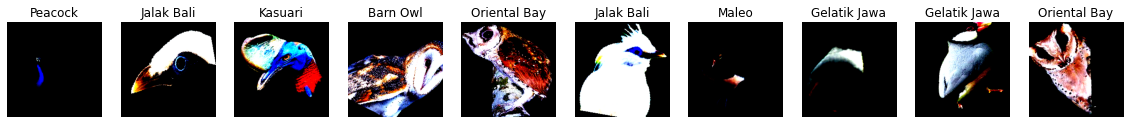

In [305]:
labels_data = {
    0: "Elang Bido",
    1: "Jalak Bali",
    2: "Barn Owl",
    3: "Kasuari",
    4: "Enggano Myna",
    5: "Elang Ikan Kepala Kelabu",
    6: "Gelatik Jawa",
    7: "Maleo",
    8: "Oriental Bay",
    9: "Peacock", 
}

fig = plt.figure(figsize=(20, 8))
cols, rows = 10,1

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_set), size=(1,)).item()

    img, label = test_set[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_data[label])
    plt.axis('off')
    img_array = img.numpy()
    img_array = img_array.transpose(1, 2, 0)
    plt.imshow(img_array)
plt.show()

In [306]:
model = torchvision.models.vgg16(pretrained=True)

In [307]:
n_inputs = model.classifier[6].in_features
classification_layer = nn.Linear(n_inputs, 10)
model.classifier[6] = classification_layer

In [308]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [309]:
model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [310]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [311]:
import torch
from torchvision import models
from torchsummary import summary

In [312]:
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [313]:
for param in model.features.parameters():
    param.requires_grad = True

In [314]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [315]:
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [316]:
train_loss = []
train_accuracy = []

valid_loss = []
valid_accuracy = []

def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    running_loss = 0.0
    running_corrects = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        _, preds = torch.max(output, dim=1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
        running_loss += loss.item()
        running_corrects += torch.sum(preds == target).item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects / len(train_loader.dataset)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    print(epoch_loss)
    print(epoch_acc)
##define test function
def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_acc= correct/len(val_loader.dataset)
    val_loss /= len(val_loader)
    valid_loss.append(val_loss)
    valid_accuracy.append(val_acc)
    print(val_loss)
    print(val_acc)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [317]:
import time
start_time = time.time()

num_epoch = 20
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        val(model, device, val_loader)
        

print("--- %s seconds ---" % (time.time() - start_time))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == "__main__":


  0%|          | 0/13 [00:00<?, ?it/s]

1.3893632132273455
0.5194174757281553
0.2831481546163559
0.9232954545454546

Test set: Average loss: 0.2831, Accuracy: 325/352 (92%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.2968788960805306
0.9029126213592233
0.21192227428158125
0.9204545454545454

Test set: Average loss: 0.2119, Accuracy: 324/352 (92%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.19035250750871804
0.933252427184466
0.1712100108464559
0.9431818181818182

Test set: Average loss: 0.1712, Accuracy: 332/352 (94%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.1272441976918624
0.9550970873786407
0.11359184918304284
0.9602272727272727

Test set: Average loss: 0.1136, Accuracy: 338/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.11070510831016761
0.9720873786407767
0.11445005610585213
0.9630681818181818

Test set: Average loss: 0.1145, Accuracy: 339/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.05187782124043084
0.9878640776699029
0.11037814042841394
0.96875

Test set: Average loss: 0.1104, Accuracy: 341/352 (97%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.055183677862469964
0.9793689320388349
0.1357245808467269
0.9602272727272727

Test set: Average loss: 0.1357, Accuracy: 338/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.04469496158596415
0.9830097087378641
0.16861526543895403
0.9460227272727273

Test set: Average loss: 0.1686, Accuracy: 333/352 (95%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.057099842108212985
0.9842233009708737
0.13800442094604173
0.9602272727272727

Test set: Average loss: 0.1380, Accuracy: 338/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.05963177584971373
0.9854368932038835
0.13774027085552612
0.9573863636363636

Test set: Average loss: 0.1377, Accuracy: 337/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.032788383290888026
0.9902912621359223
0.1527868943909804
0.9488636363636364

Test set: Average loss: 0.1528, Accuracy: 334/352 (95%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.02123700892731834
0.9902912621359223
0.14897827493647733
0.9403409090909091

Test set: Average loss: 0.1490, Accuracy: 331/352 (94%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.02811094697860356
0.991504854368932
0.14655313392480215
0.9573863636363636

Test set: Average loss: 0.1466, Accuracy: 337/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.06609241019647855
0.9745145631067961
0.1507535483688116
0.9602272727272727

Test set: Average loss: 0.1508, Accuracy: 338/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.03817638328585487
0.9878640776699029
0.12593398181100687
0.96875

Test set: Average loss: 0.1259, Accuracy: 341/352 (97%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.038745058834767684
0.9902912621359223
0.09190172636105369
0.9630681818181818

Test set: Average loss: 0.0919, Accuracy: 339/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.020074978846913345
0.9939320388349514
0.07670829724520445
0.9801136363636364

Test set: Average loss: 0.0767, Accuracy: 345/352 (98%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.008928737710588254
0.9987864077669902
0.08263453934341669
0.9744318181818182

Test set: Average loss: 0.0826, Accuracy: 343/352 (97%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.008160704313643062
0.9963592233009708
0.11433973248737554
0.9630681818181818

Test set: Average loss: 0.1143, Accuracy: 339/352 (96%)



  0%|          | 0/13 [00:00<?, ?it/s]

0.00753112980545176
0.9975728155339806
0.07757102216904362
0.9801136363636364

Test set: Average loss: 0.0776, Accuracy: 345/352 (98%)

--- 231.31566786766052 seconds ---


In [318]:


dictionary = {
    'train_loss':train_loss,
    'train_accuracy':train_accuracy,
    'val_loss':valid_loss,
    'val_accuracy':valid_accuracy
}
metrics = pd.DataFrame(dictionary)
metrics

,train_loss,train_accuracy,val_loss,val_accuracy
0,1.389363,0.519417,0.283148,0.923295
1,0.296879,0.902913,0.211922,0.920455
2,0.190353,0.933252,0.171210,0.943182
3,0.127244,0.955097,0.113592,0.960227
4,0.110705,0.972087,0.114450,0.963068
5,0.051878,0.987864,0.110378,0.968750
6,0.055184,0.979369,0.135725,0.960227
7,0.044695,0.983010,0.168615,0.946023
8,0.057100,0.984223,0.138004,0.960227
9,0.059632,0.985437,0.137740,0.957386


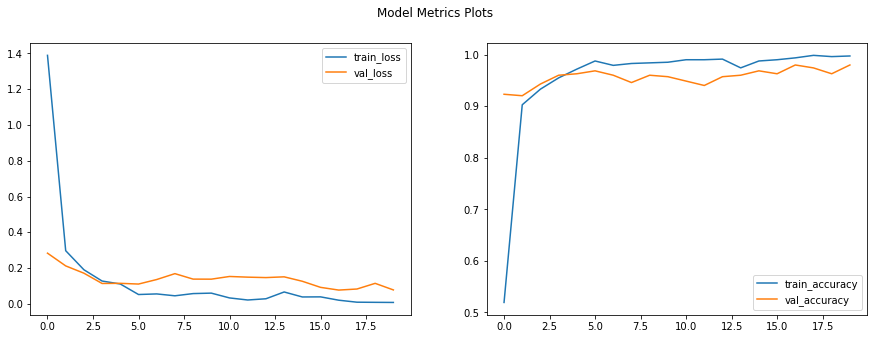

In [319]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Metrics Plots')

ax1.plot(metrics[['train_loss', 'val_loss']])
ax1.legend(['train_loss', 'val_loss'], loc="upper right")

ax2.plot(metrics[['train_accuracy', 'val_accuracy']])
ax2.legend(['train_accuracy', 'val_accuracy'], loc="lower right");

In [320]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = []
y_true = []

for data, labels in test_loader:
        data = data.to(torch.device('cuda'))
        output = model(data) # Feed Network
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

classes = ("Elang Bido","Jalak bali","Barn Owl","Cassowary","Enggano Myna","Grey Head Fish Eagle","Java Sparrow","Maleo","Oriental Bay Owl","Peacock")


              precision    recall  f1-score   support

           0       0.92      0.96      0.94        51
           1       1.00      1.00      1.00        40
           2       0.98      1.00      0.99        51
           3       1.00      0.98      0.99        51
           4       1.00      1.00      1.00        57
           5       0.93      0.91      0.92        47
           6       1.00      1.00      1.00        56
           7       0.98      0.97      0.97        58
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        50

    accuracy                           0.98       504
   macro avg       0.98      0.98      0.98       504
weighted avg       0.98      0.98      0.98       504



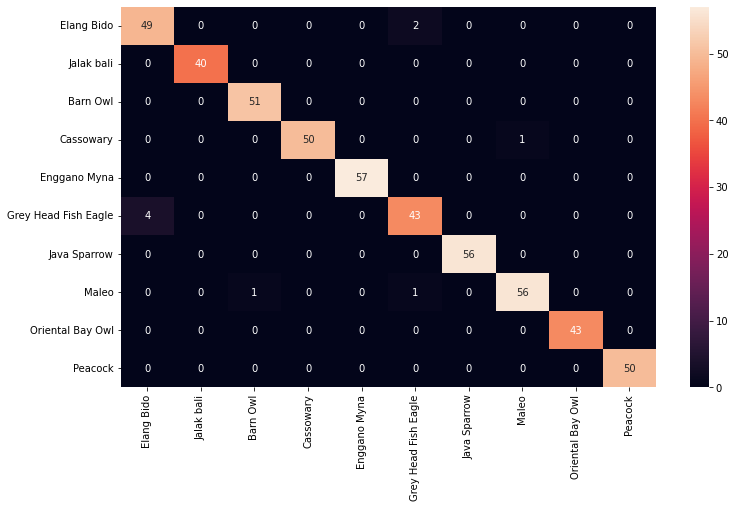

In [321]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, fmt="d",annot=True)
print(classification_report(y_true, y_pred))

In [322]:
def test(model):
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    model.eval()

    for data, target in tqdm(test_loader):
        if torch.cuda.is_available(): 
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        if len(target) == 64:
            for i in range(64):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [323]:
test(model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.102565

Test Accuracy of Elang Bido: 89% (43/48)
Test Accuracy of Jalak bali: 100% (35/35)
Test Accuracy of Barn Owl: 100% (49/49)
Test Accuracy of Cassowary: 100% (46/46)
Test Accuracy of Enggano Myna: 100% (51/51)
Test Accuracy of Grey Head Fish Eagle: 89% (41/46)
Test Accuracy of Java Sparrow: 100% (50/50)
Test Accuracy of Maleo: 95% (46/48)
Test Accuracy of Oriental Bay Owl: 100% (37/37)
Test Accuracy of Peacock: 100% (38/38)

Test Accuracy (Overall): 97.3214 (436.0/448.0)


In [324]:
torch.save(model.state_dict(), "Model_VGG16_Wheat Leaves_without pretrained.pth")